In [1]:
import os
import sys

project_dir = os.path.realpath(os.path.join(os.getcwd(), '..','..','..','..'))
data_dir = os.path.join(project_dir, 'ORATS','parquet')
tickerdata_dir = os.path.join(project_dir, 'ORATS','byticker')
data_clean_dir = os.path.join(project_dir, 'repository','utils')

sys.path.append(data_clean_dir)

In [90]:
import imp
import anomaly_detection_class
imp.reload(anomaly_detection_class)
from anomaly_detection_class import anomalyDetector

In [27]:
from orats_cleaner import *
from workers import get_all_price
from anomaly_detection_class import anomalyDetector
from anomaly_detection_helper import train_test_split
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [5]:
filelist = generate_file_list(data_dir, '201901','202105')

In [4]:
tickers = ['ATVI', 'KSS', 'MSFT', 'NKE', 'PTON', 'TD']

In [6]:
optiondata = read_optiondata_by_ticker(filelist, tickers)
filename = 'VIXsymbol_data1.parquet'
optiondata.to_parquet(filename)

D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201901.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201902.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201903.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201904.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201905.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201906.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201907.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201908.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201909.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201910.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201911.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201912.parquet done!
D:\jupyter\wooji\ORATS\parquet\2020\ORATS_SMV_Stries_202001.parquet done!
D:\jupyter\wooji\ORATS\parquet\2020\OR

In [59]:
B2 = {'variable':['volume','impliedvol'], 
        'direction':['>','>'], 
        'volume_operation':'sum', 
        'window':60, 
        'log_trans':False}

thresh = [1.2,0.3]

split_date = '2019-06-01'
window = 60
win_thresh = -0.01

In [91]:
ad_dic = {}
outlier_dates = {}
next5thday_ret_dic = {}
for t in tickers:
    _, test = train_test_split(optiondata[optiondata['underlying']==t], split_date, window=window)
    ad = anomalyDetector()
    ad.compile(_type='call', expiry='next', monthly=True, moneyness='otm', params=B2)
    
    next5thday_ret_dic[t] = ad.predict(test, win_thresh, thresh, verbose=True)
    ad_dic[t] = ad
    outlier_dates[t] = ad._test_outlier

+1 day stock price increase probability: 0.805
+1 day stock price avg increase: 0.017
+1 day stock price avg decrease -0.019 

+5 day stock price increase probability: 0.756
+5 day stock price avg increase: 0.04
+5 day stock price avg decrease: -0.026
+5 day expected return: 0.023896 

+1 day stock price increase probability: 0.52
+1 day stock price avg increase: 0.045
+1 day stock price avg decrease -0.064 

+5 day stock price increase probability: 0.84
+5 day stock price avg increase: 0.09
+5 day stock price avg decrease: -0.117
+5 day expected return: 0.05688 

+1 day stock price increase probability: 0.796
+1 day stock price avg increase: 0.015
+1 day stock price avg decrease -0.015 

+5 day stock price increase probability: 0.776
+5 day stock price avg increase: 0.033
+5 day stock price avg decrease: -0.035
+5 day expected return: 0.017768000000000003 

+1 day stock price increase probability: 0.848
+1 day stock price avg increase: 0.016
+1 day stock price avg decrease -0.012 

+5

In [31]:
start = '2019-01-01'
end = '2021-06-20'
vix = get_all_price(['^VIX'],start,end)

[*********************100%***********************]  1 of 1 completed


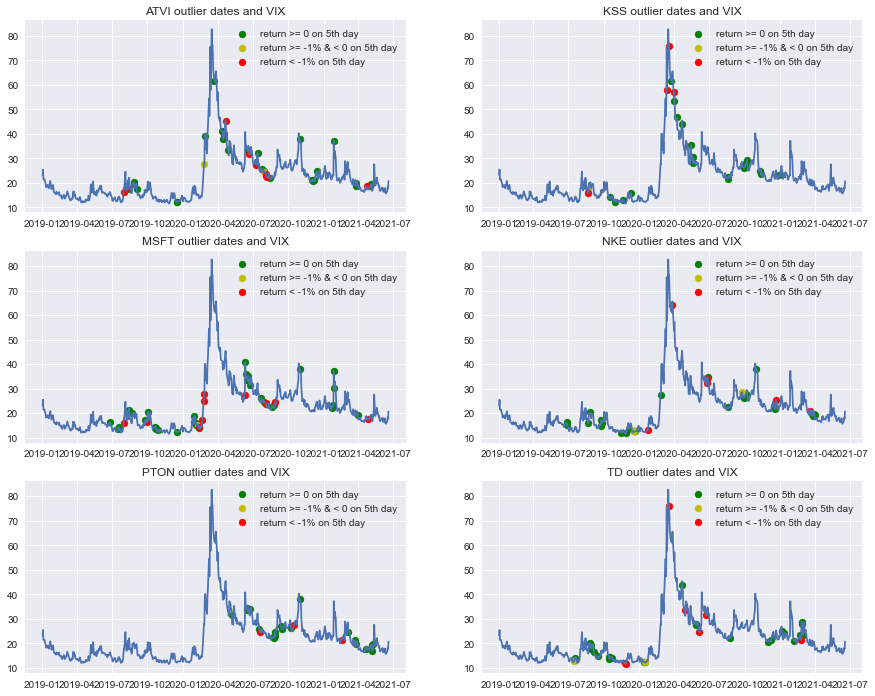

In [93]:
fig, axes = plt.subplots(3,2, figsize=(15, 12))
axes = axes.ravel()
for i, t in enumerate(tickers):
    next5thday_ret = next5thday_ret_dic[t]['5thday_return']
    ret_pos_date = next5thday_ret[next5thday_ret>=0].index
    ret_neg1_date = next5thday_ret[(next5thday_ret>=-0.01) & (next5thday_ret<0)].index
    ret_neg2_date = next5thday_ret[next5thday_ret<-0.01].index
    
    axes[i].plot(vix['close'])
    axes[i].scatter(ret_pos_date, vix['close'].loc[ret_pos_date], c='g', label='return >= 0 on 5th day')
    axes[i].scatter(ret_neg1_date, vix['close'].loc[ret_neg1_date], c='y', label='return >= -1% & < 0 on 5th day')
    axes[i].scatter(ret_neg2_date, vix['close'].loc[ret_neg2_date], c='r', label='return < -1% on 5th day')
    axes[i].legend()
    axes[i].set_title(t+' outlier dates and VIX')